In [ ]:
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper
from gymnasium.wrappers import ResizeObservation
# import env_wrapper
from pprint import pprint
envs = [env_id for env_id in gymnasium.envs.registry.keys() if "MiniGrid" in env_id]
pprint(sorted(envs)[:10])


ModuleNotFoundError: No module named 'env_wrapper'

In [ ]:
env_names = ["MiniGrid-Empty-8x8-v0", "MiniGrid-SimpleCrossingS9N3-v0", "MiniGrid-DoorKey-8x8-v0", "MiniGrid-FourRooms-v0"] 

In [21]:
env = gym.make("MiniGrid-DoorKey-16x16-v0")
env = RGBImgPartialObsWrapper(env)  # Adds an "rgb" key to the obs
env = ImgObsWrapper(env)     # Sets obs = obs["rgb"], discards others
env = ResizeObservation(env, shape=(64,64))

In [35]:
obs, info = env.reset()
obs.shape, info
# env.render()

((64, 64, 3), {})

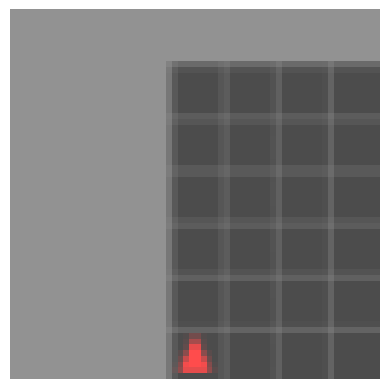

In [36]:
import matplotlib.pyplot as plt

plt.imshow(obs)
plt.axis('off')
plt.show()

In [14]:
obs["image"].shape

(7, 7, 3)

In [ ]:
import gymnasium as gym
env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = policy(observation)  # User-defined policy function
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()
env.close()

In [33]:
def build_single_env(env_name: str, image_size: int, seed: int = 0):
    """
    Build a single env with wrappers and preprocesses env.
    """
    env = gymnasium.make(
        env_name, render_mode="rgb_array")
    # Convert int to tuple as gymnasium.wrappers.ResizeObservation requires tuple
    if isinstance(image_size, int):
        image_size = (image_size, image_size)
    env = minigrid.wrappers.RGBImgPartialObsWrapper(env)  # Adds an "rgb" key to the obs
    env = minigrid.wrappers.ImgObsWrapper(env)  # Sets obs = obs["rgb"], discards others
    env = gymnasium.wrappers.ResizeObservation(env, shape=image_size)
    # env = env_wrapper.LifeLossInfo(env)

    return env

In [34]:
env_names = ["MiniGrid-Empty-8x8-v0", "MiniGrid-SimpleCrossingS9N3-v0", "MiniGrid-DoorKey-8x8-v0", "MiniGrid-FourRooms-v0"] 
env = build_single_env(env_names[0], image_size=64)

In [41]:
def build_vec_env(env_names: list[str], image_size: int):
    """
    Build a vectorized env with n=num_envs parallel envs.
    """

    # lambda pitfall refs to: https://python.plainenglish.io/python-pitfalls-with-variable-capture-dcfc113f39b7
    def lambda_generator(env_name, image_size):
        return lambda: build_single_env(env_name, image_size)

    env_fns = []
    env_fns = [lambda_generator(env_name, image_size) for env_name in env_names]
    vec_env = gymnasium.vector.AsyncVectorEnv(env_fns=env_fns)
    return vec_env
